In [1]:
""" LOAD DATA """

from scipy import misc
import glob
import os
import numpy as np

color_imgs = []
depth_imgs = []
for image_path in glob.glob('../data/resized/color/*.jpg'):
    path, file_name = os.path.split(image_path)
    c_im = misc.imread(image_path)
    d_im = misc.imread(os.path.join('../data/resized/depthCorrected', file_name[:-3]+'png'))
    color_imgs.append(c_im)
    depth_imgs.append(d_im)

/home/acar/.virtualenvs/gpuenv/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
/home/acar/.virtualenvs/gpuenv/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]


In [2]:
""" TRAIN TEST SPLIT """

from sklearn.model_selection import train_test_split

SUB_SAMPLE = 1
step = np.int32(1/SUB_SAMPLE)
x_train, x_test, y_train, y_test = train_test_split(np.asarray(color_imgs[0:-1:step]), np.asarray(depth_imgs[0:-1:step]), test_size=0.20, random_state=42)

In [3]:
""" NORMALIZATION """

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train = y_train.astype('float32') / (2**16)
y_test = y_test.astype('float32') / (2**16)

y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))

In [9]:
""" DEFINE MODEL """

import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.models import Model
from keras.layers import Dense
from capsule_layers import PrimaryCap
from capsule_layers import CapsuleLayer
from capsule_layers import Length
from capsule_layers import Mask
from keras.layers import Lambda
from keras import layers, models, optimizers
from keras import callbacks
from keras.activations import softmax

in_shape = color_imgs[0].shape
input_img = Input(shape=in_shape)

# conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', 
#                       activation='relu', name='conv1')(input_img)
# primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=16, kernel_size=9, strides=2, padding='valid')
# digitcaps = CapsuleLayer(num_capsule=5, dim_capsule=16, num_routing=3,
#                          name='digitcaps')(primarycaps)
# digitcaps2 = CapsuleLayer(num_capsule=1, dim_capsule=24, num_routing=3,
#                          name='digitcaps2')(primarycaps)

ks = 3

x = layers.Conv2D(16, (ks, ks), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (ks, ks), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (ks, ks), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (ks, ks), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (ks, ks), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# encoded = digitcaps2

x = encoded
x = layers.Conv2D(64, (ks, ks), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (ks, ks), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (ks, ks), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (ks, ks), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (ks, ks), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (ks, ks), activation='sigmoid', padding='same')(x)

# x = Dense(11552, activation='relu')(encoded)
# x = layers.Reshape(target_shape=(38, 38, 8))(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(16, (3, 3), activation='relu')(x)
# x = layers.UpSampling2D((2, 2))(x)
# decoded = layers.Conv2D(NUM_CLASSES, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
evalmodel = Model(input_img, [decoded, encoded])
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
__________

In [11]:
cb = [callbacks.ModelCheckpoint('checkpoints/conv_ae_best.hdf5',
                                             verbose=0,
                                             save_weights_only=False, save_best_only=True)]

history = autoencoder.fit(x_train, y_train, batch_size=64, epochs=30, 
                          validation_data=(x_test,y_test), shuffle=True,
                         callbacks=cb)

Train on 8197 samples, validate on 2050 samples
Epoch 1/30
8197/8197 [==============================] - 79s 10ms/step - loss: 0.1666 - val_loss: 0.1702
Epoch 2/30
8197/8197 [==============================] - 78s 10ms/step - loss: 0.1665 - val_loss: 0.1685
Epoch 3/30
8197/8197 [==============================] - 79s 10ms/step - loss: 0.1662 - val_loss: 0.1695
Epoch 4/30
8197/8197 [==============================] - 78s 10ms/step - loss: 0.1662 - val_loss: 0.1708
Epoch 5/30
8197/8197 [==============================] - 78s 10ms/step - loss: 0.1664 - val_loss: 0.1681
Epoch 6/30
8197/8197 [==============================] - 79s 10ms/step - loss: 0.1657 - val_loss: 0.1682
Epoch 7/30
8197/8197 [==============================] - 78s 10ms/step - loss: 0.1655 - val_loss: 0.1686
Epoch 8/30
8197/8197 [==============================] - 79s 10ms/step - loss: 0.1653 - val_loss: 0.1698
Epoch 9/30
8197/8197 [==============================] - 78s 10ms/step - loss: 0.1657 - val_loss: 0.1712
Epoch 10/30
8197

In [12]:
""" EVALUATE CONVOLUTIONAL MODEL """

autoencoder = load_model('checkpoints/conv_ae_best.hdf5')
eval_model = Model(autoencoder.input, autoencoder.output)
eval_model.compile(optimizer='adam', loss='mse')
eval_model.evaluate(x_test, y_test*327.675, batch_size=1, verbose=1)

2050/2050 [==============================] - 17s 9ms/step


41167.92439500762

In [13]:
from keras.models import load_model

autoencoder = load_model('checkpoints/conv_ae_best.hdf5')
predicted = autoencoder.predict(x_train, verbose=1, batch_size=64)

8197/8197 [==============================] - 28s 3ms/step


In [14]:
import numpy as np

def histeq(image, number_bins=256):
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)

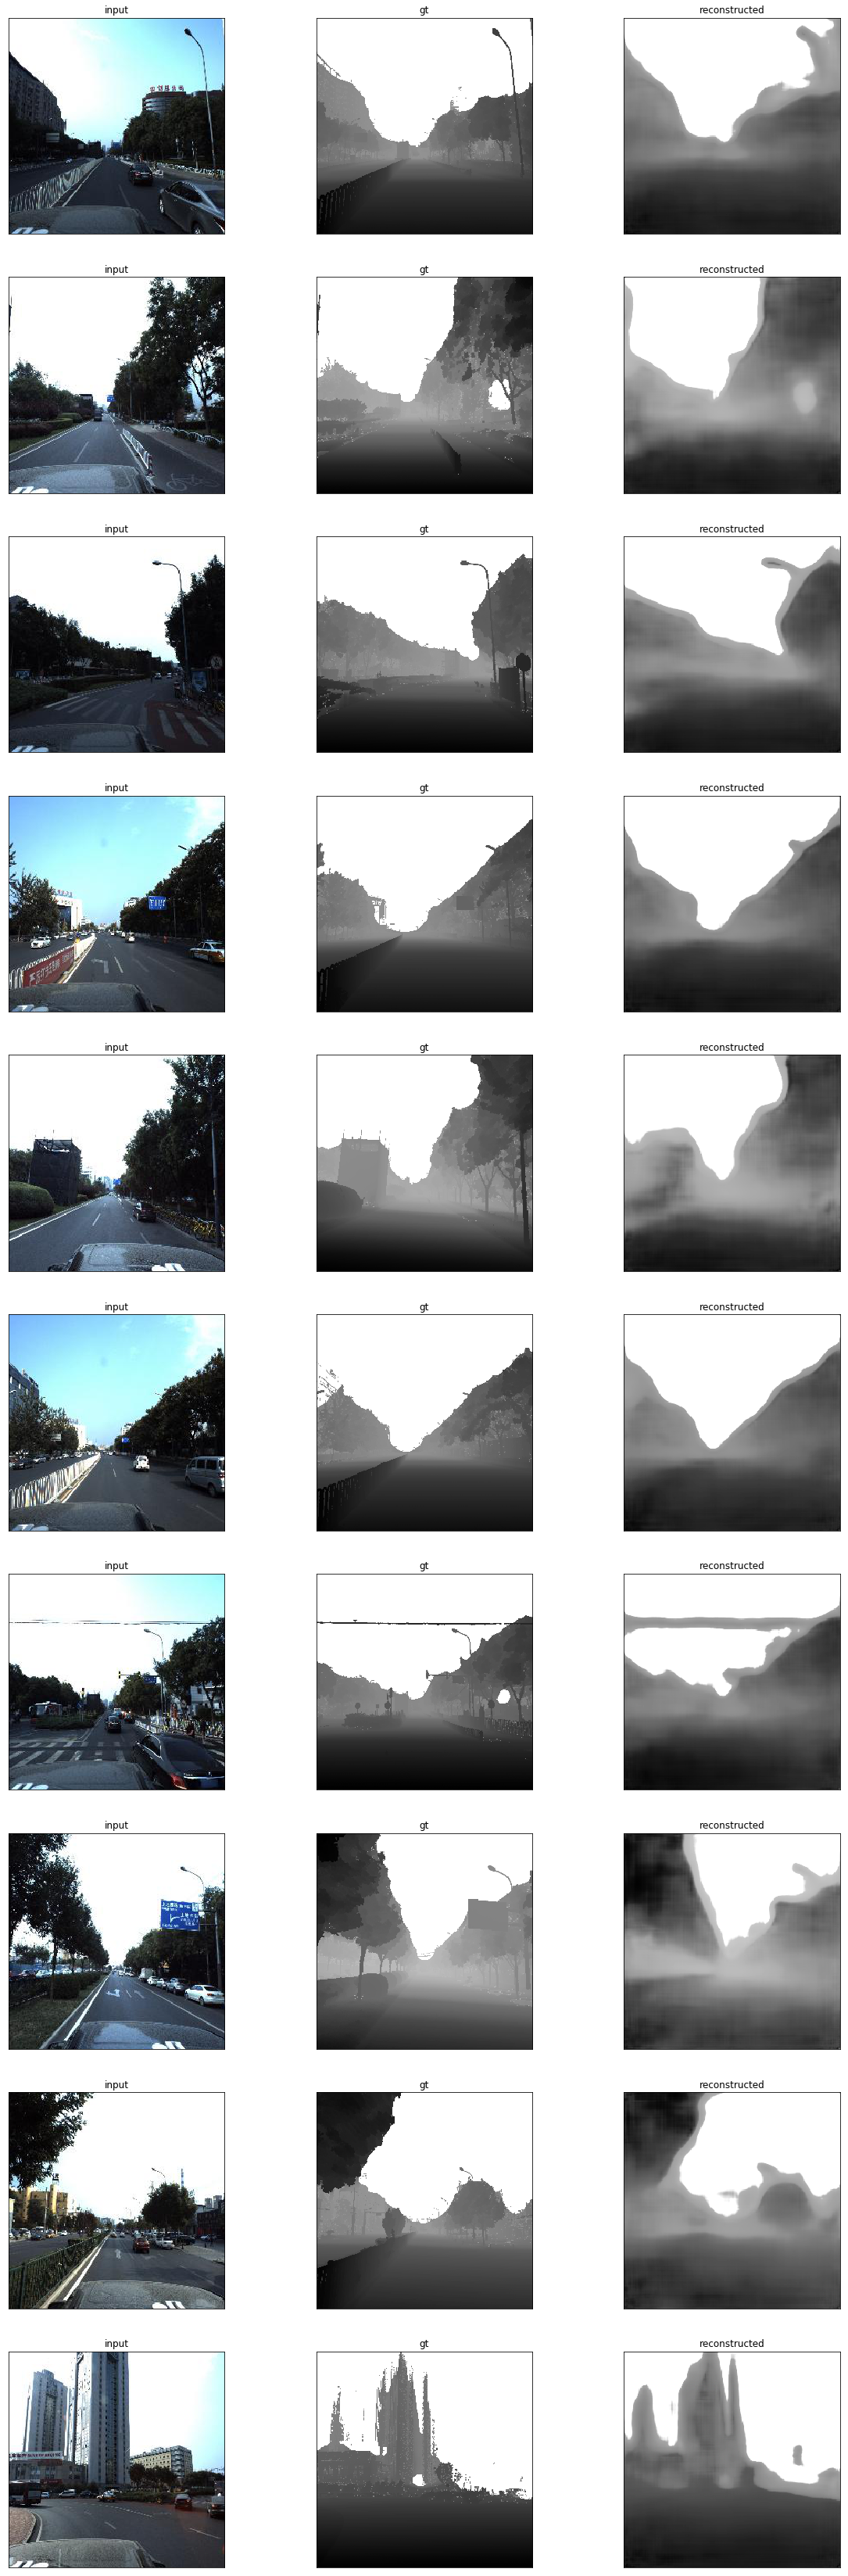

In [15]:
from PIL import Image
n = 10
o = 40
c = 1
plt.figure(figsize=(20, 60))
for i in range(n):    
    # display original img
    ax = plt.subplot(n, 3, i*3+1)
    plt.imshow(x_train[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("input")
    
    # display gt
    ax = plt.subplot(n, 3, i*3+2)
    plt.imshow(histeq(y_train[i,:,:,0]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("gt")
    
    # display reconstruction
    ax = plt.subplot(n, 3, i*3+3)
    plt.imshow(histeq(predicted[i,:,:,0]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("reconstructed")
plt.show()